# Inference of parameters with latent variables (SEIR model)
In this notebook, we consider the SEIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{E}$ (rate from exposed to infected)
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 


when partially observed data ($I_s$ only) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

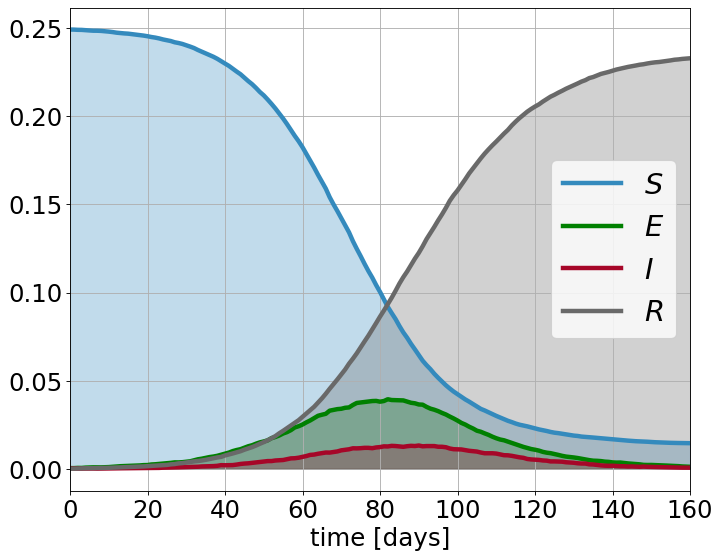

In [3]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Inference
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

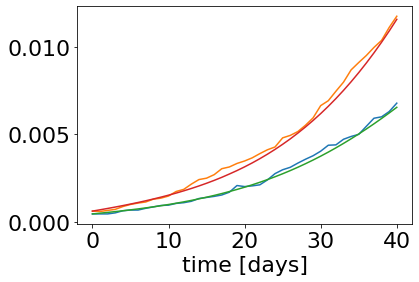

In [4]:
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = estimator.make_det_model(parameters)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference, det_model, contactMatrix)

plt.plot(obs[:, -2:])
plt.plot(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


In [5]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}
estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=False)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-1246.6769262931566
0.2659740447998047


In [6]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

beta_g = 0.02
beta_std = 0.1
beta_bounds = (eps, 1)

gIa_g = 0.12
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.14
gIs_std = 0.05
gIs_bounds = (eps, 1) 

gE_g = 0.1
gE_std = 0.05 
gE_bounds = (eps, 0.2) 

fsa_g = 0.8 # not inferred 

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 200/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 200/N], M).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                   *bounds_for_E, *bounds_for_Ia])
guess = np.array([beta_g, gIa_g, gIs_g, gE_g, *E0_g, *Ia0_g])
stds = np.array([beta_std, gIa_std, gIs_std, gE_std, *E_std, *Ia_std])
init_fltr = np.repeat([False, True, True, False], M)
param_keys = ['beta', 'gIa', 'gIs', 'gE']
start_time = time.time()
params = estimator.latent_infer_parameters(param_keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True,
                                    global_max_iter=20, global_atol=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=151252691, Wed Jun 10 16:12:10 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.044172328925750e+03 1.0e+00 8.92e-01  3e-04  9e-02 0:00.2
    2     32 -1.133016407764795e+03 1.2e+00 8.56e-01  3e-04  9e-02 0:00.4
    3     48 -1.157216358736835e+03 1.3e+00 9.31e-01  3e-04  9e-02 0:00.6
   20    320 -1.019508982334394e+03 3.8e+00 1.05e+00  5e-04  8e-02 0:03.6
Optimal value (global minimisation):  -1266.0375096889948
Starting local minimisation...
Optimal value (local minimisation):  -1273.187961283111
4.875109910964966


In [7]:
# save the parameters 
np.save('SEIR_latent_param.npy', params)

In [8]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(parameters, logp)

print('\n True initial conditions: ') 
print((x0*N).astype('int'))


params = np.load('SEIR_latent_param.npy')
best_estimates = estimator.fill_params_dict(param_keys, params)

partial_inits = params[len(param_keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

print('\n Best estimates')
print(best_estimates, logp)


print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((4, M)), axis=0)))

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 0.8} -1246.6769262931566

 True initial conditions: 
[12269 37264   107   101    25    18    23    31]

 Best estimates
{'alpha': array([0.5, 0.2]), 'beta': 0.024146795188469888, 'gIa': 0.20789809104833365, 'gIs': 0.13255835948081746, 'gE': 0.08816811808251394, 'fsa': array([0.8, 0.8])} -1244.5494443070318

 Inferred initial conditons: 
[12290 37236    92   128    18    17    23    31]
R initial =  [76. 86.]


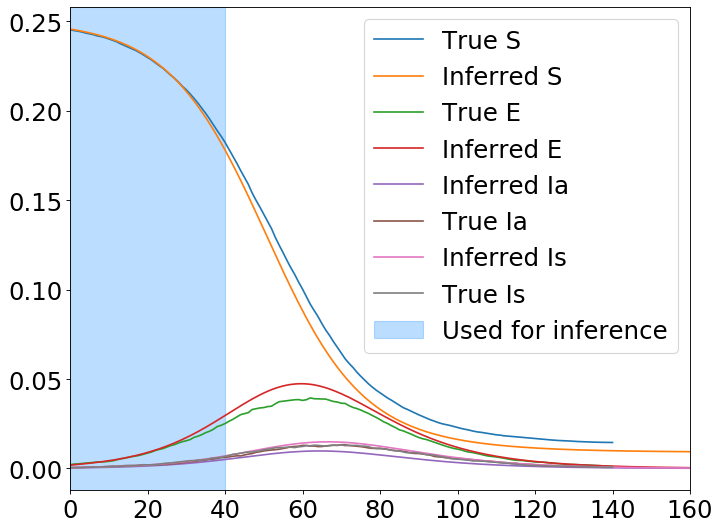

In [10]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
partial_inits = params[len(param_keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]/N 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(x_det[:, 3*M], label='Inferred Is')
plt.plot(x[:,3*M], label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()